# Train a convolutional neural network to predict MHC ligands
The notebook consists of the following sections:

0. Module imports, define functions, set constants
1. Load Data
2. Build Model
3. Select Hyper-paramerters
4. Compile Model
5. Train Model
6. Evaluation

## Exercise

The exercise shows how the general performance is maintained and perhaps even elevated with the use of CNN when we have peptides of different lengths.

### Performance evaluation
Run the notebook and take a look at how the model performs on data partitioned by peptide length. 

1. What happens to the overall performance (on peptides of all lengths) compared to FFNN?
2. What happens to the performance evaluated only on peptides on length 9? Compare to FFNN again.
3. What happens to the performance evaluated on 8-10-11mers (excluding 9mers)? Compare to FFNN again.

Can you explain why we would prefer a good performance on 8-9-10-11mers over a higher performance on only 9mers?

## ... and you're done!

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from pytorchtools import EarlyStopping

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

In [4]:
SEED=1
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep='\s+', comment='#', index_col=0)
    return df.loc[aa, aa]

In [6]:
def load_peptide_target(filename):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep='\s+', usecols=[0,1], names=['peptide','target'])
    return df[df.peptide.apply(len) <= MAX_PEP_SEQ_LEN]

In [7]:
def encode_peptides(Xin):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a tensor of encoded peptides of shape (batch_size, MAX_PEP_SEQ_LEN, n_features)
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(Xin)
    n_features = len(blosum)
    
    Xout = np.zeros((batch_size, MAX_PEP_SEQ_LEN, n_features), dtype=np.int8) # should it be uint? is there a purpose to that?
    
    for peptide_index, row in Xin.iterrows():
        for aa_index in range(len(row.peptide)):
            Xout[peptide_index, aa_index] = blosum[ row.peptide[aa_index] ].values
            
    return Xout, Xin.target.values

In [8]:
def invoke(early_stopping, loss, model, implement=False):
    if implement == False:
        return False
    else:
        early_stopping(loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            return True

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def plot_target_values(data):
    plt.figure(figsize=(15,4))
    for partition, label in data:
        x = partition.index
        y = partition.target
        plt.scatter(x, y, label=label, marker='.')
    plt.axhline(y=BINDER_THRESHOLD, color='r', linestyle='--', label='Binder threshold')
    plt.legend(frameon=False)
    plt.title('Target values')
    plt.xlabel('Index of dependent variable')
    plt.ylabel('Dependent varible')
    plt.show()

## Arguments

In [11]:
MAX_PEP_SEQ_LEN = 11
BINDER_THRESHOLD = 0.426

# Main

## Load

In [12]:
ALLELE = 'A0301'

In [13]:
blosum_file = "../data/BLOSUM50"
train_data = "../data/%s/train_BA" % ALLELE
valid_data = "../data/%s/valid_BA" % ALLELE
test_data = "../data/%s/test_BA" % ALLELE

In [14]:
train_raw = load_peptide_target(train_data)
valid_raw = load_peptide_target(valid_data)
test_raw = load_peptide_target(test_data)

### Encode data

In [15]:
x_train_, y_train_ = encode_peptides(train_raw)
x_valid_, y_valid_ = encode_peptides(valid_raw)
x_test_, y_test_ = encode_peptides(test_raw)

Check the data dimensions for the train set and validation set (batch_size, MAX_PEP_SEQ_LEN, n_features)

In [16]:
print(x_train_.shape)
print(x_valid_.shape)
print(x_test_.shape)

(3951, 11, 21)
(1329, 11, 21)
(1321, 11, 21)


In [17]:
batch_size = x_train_.shape[0]
n_features = x_train_.shape[1]

### Make data iterable

In [18]:
x_train = Variable(torch.from_numpy(x_train_.astype('float32')))
y_train = Variable(torch.from_numpy(y_train_.astype('float32'))).view(-1, 1)
x_valid = Variable(torch.from_numpy(x_valid_.astype('float32')))
y_valid = Variable(torch.from_numpy(y_valid_.astype('float32'))).view(-1, 1)
x_test = Variable(torch.from_numpy(x_test_.astype('float32')))
y_test = Variable(torch.from_numpy(y_test_.astype('float32'))).view(-1, 1)

## Build Model

In [19]:
class CNNpep(nn.Module):
    
    def __init__(self, n_filters, k, n_l1):
        super(CNNpep, self).__init__()
        self.conv_layer = nn.Conv1d(in_channels=21, 
                                    out_channels=n_filters,
                                    kernel_size=k, 
                                    stride=1,
                                    padding=0)
        
        self.fc1 = nn.Linear(n_filters, n_l1)
        self.fc2 = nn.Linear(n_l1, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Permutation of the dimensions for the cnn
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv_layer(x))
        x, _ = torch.max(x, axis=2)
        x = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x))
        
        return out
        

## Select Hyper-parameters

In [20]:
def init_weights(m):
    """
    https://pytorch.org/docs/master/nn.init.html
    """
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0) # alternative command: m.bias.data.fill_(0.01)

In [21]:
EPOCHS = 3000
MINI_BATCH_SIZE = 512
N_HIDDEN_NEURONS = 16
LEARNING_RATE = 0.1
PATIENCE = EPOCHS // 10

## Train Model

In [22]:
net = CNNpep(n_filters=100, k=3, n_l1=16)

optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def train():
    train_loss, valid_loss = [], []

    early_stopping = EarlyStopping(patience=PATIENCE)

    for epoch in range(EPOCHS):
        net.train()
        pred = net(x_train)
        loss = criterion(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data)

        net.eval()
        pred = net(x_valid)
        loss = criterion(pred, y_valid)  
        valid_loss.append(loss.data)
        
        if epoch % (EPOCHS//10) == 0:
            print('Train Epoch: {}\tLoss: {:.6f}\tVal Loss: {:.6f}'.format(epoch, train_loss[-1], valid_loss[-1]))

        if invoke(early_stopping, valid_loss[-1], net, implement=True):
            net.load_state_dict(torch.load('checkpoint.pt'))
            break
            
    return net, train_loss, valid_loss

In [23]:
net, train_loss, valid_loss = train()

Train Epoch: 0	Loss: 0.070979	Val Loss: 0.072850
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStopping counter: 7 out of 300
EarlyStopping counter: 8 out of 300
EarlyStopping counter: 9 out of 300
EarlyStopping counter: 10 out of 300
EarlyStopping counter: 11 out of 300
EarlyStopping counter: 12 out of 300
EarlyStopping counter: 13 out of 300
EarlyStopping counter: 14 out of 300
EarlyStopping counter: 15 out of 300
Train Epoch: 300	Loss: 0.049481	Val Loss: 0.052036
EarlyStopping counter: 16 out of 300
EarlyStopping counter: 17 out of 300
EarlyStopping counter: 18 out of 300
EarlyStopping counter: 19 out of 300
EarlyStopping counter: 20 out of 300
EarlyStopping counter: 21 out of 300
EarlyStopping counter: 22 out of 300
EarlyStopping counter: 

EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out

EarlyStopping counter: 41 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStopping counter: 7 out of 300
EarlyStopping counter: 8 out of 300
EarlyStopping counter: 9 out of 300
EarlyStopping counter: 10 out of 300
EarlyStopping counter: 11 out of 300
EarlyStopping counter: 12 out of 300
EarlyStopping counter: 13 out of 300
EarlyStopping counter: 14 out of 300
EarlyStopping counter: 15 out of 300
EarlyStopping counter: 16 out of 300
EarlyStopping counter: 17 out of 300
EarlyStopping count

EarlyStopping counter: 17 out of 300
EarlyStopping counter: 18 out of 300
EarlyStopping counter: 19 out of 300
EarlyStopping counter: 20 out of 300
EarlyStopping counter: 21 out of 300
EarlyStopping counter: 22 out of 300
EarlyStopping counter: 23 out of 300
EarlyStopping counter: 24 out of 300
EarlyStopping counter: 25 out of 300
EarlyStopping counter: 26 out of 300
EarlyStopping counter: 27 out of 300
EarlyStopping counter: 28 out of 300
EarlyStopping counter: 29 out of 300
EarlyStopping counter: 30 out of 300
EarlyStopping counter: 31 out of 300
EarlyStopping counter: 32 out of 300
EarlyStopping counter: 33 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStoppi

EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStopping counter: 7 out of 300
EarlyStopping counter: 8 out of 300
EarlyStopping counter: 9 out of 300
EarlyStopping counter: 10 out of 300
EarlyStopping counter: 11 out of 300
EarlyStopping counter: 12 out of 300
EarlyStopping counter: 13 out of 300
EarlyStopping counter: 14 out of 300
EarlyStopping counter: 15 out of 300
EarlyStopping counter: 16 out of 300
EarlyStopping counter: 17 out of 300
EarlyStopping counter: 18 out of 300
EarlyStopping counter: 19 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping coun

EarlyStopping counter: 95 out of 300
EarlyStopping counter: 96 out of 300
EarlyStopping counter: 97 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStopping counter: 7 out of 300
EarlyStopping counter: 8 out of 300
EarlyStopping counter: 9 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStopping counter: 7 out of 300
EarlyStopping counter: 8 out of 300
EarlyStopping counter: 9 out of 300
EarlyStopping counter: 10 out of 300
EarlyStopping counter: 1

EarlyStopping counter: 19 out of 300
EarlyStopping counter: 20 out of 300
EarlyStopping counter: 21 out of 300
EarlyStopping counter: 22 out of 300
EarlyStopping counter: 23 out of 300
EarlyStopping counter: 24 out of 300
EarlyStopping counter: 25 out of 300
EarlyStopping counter: 26 out of 300
EarlyStopping counter: 27 out of 300
EarlyStopping counter: 28 out of 300
EarlyStopping counter: 29 out of 300
EarlyStopping counter: 30 out of 300
EarlyStopping counter: 31 out of 300
EarlyStopping counter: 32 out of 300
EarlyStopping counter: 33 out of 300
EarlyStopping counter: 34 out of 300
EarlyStopping counter: 35 out of 300
EarlyStopping counter: 36 out of 300
EarlyStopping counter: 37 out of 300
EarlyStopping counter: 38 out of 300
EarlyStopping counter: 39 out of 300
EarlyStopping counter: 40 out of 300
EarlyStopping counter: 41 out of 300
EarlyStopping counter: 42 out of 300
EarlyStopping counter: 43 out of 300
EarlyStopping counter: 44 out of 300
EarlyStopping counter: 45 out of 300
E

EarlyStopping counter: 15 out of 300
EarlyStopping counter: 16 out of 300
EarlyStopping counter: 17 out of 300
EarlyStopping counter: 18 out of 300
EarlyStopping counter: 19 out of 300
EarlyStopping counter: 20 out of 300
EarlyStopping counter: 21 out of 300
EarlyStopping counter: 22 out of 300
EarlyStopping counter: 23 out of 300
EarlyStopping counter: 24 out of 300
EarlyStopping counter: 25 out of 300
EarlyStopping counter: 26 out of 300
EarlyStopping counter: 27 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 1 out of 300
EarlyStopping counter: 2 out of 300
EarlyStopping counter: 3 out of 300
EarlyStopping counter: 4 out of 300
EarlyStopping counter: 5 out of 300
EarlyStopping counter: 6 out of 300
EarlyStopping counter: 7 out of 300
EarlyStopping counter: 8 out of 300
EarlyStopping counter: 9 out of 300
EarlyStopping counter: 10 out of 300
EarlyStopping counter: 11 out of 300
EarlyStopping counter: 12 out of 300
EarlyStopping counter: 13 out of 300
EarlyStoppi

EarlyStopping counter: 123 out of 300
EarlyStopping counter: 124 out of 300
EarlyStopping counter: 125 out of 300
EarlyStopping counter: 126 out of 300
EarlyStopping counter: 127 out of 300
EarlyStopping counter: 128 out of 300
EarlyStopping counter: 129 out of 300
EarlyStopping counter: 130 out of 300
EarlyStopping counter: 131 out of 300
EarlyStopping counter: 132 out of 300
EarlyStopping counter: 133 out of 300
EarlyStopping counter: 134 out of 300
EarlyStopping counter: 135 out of 300
EarlyStopping counter: 136 out of 300
EarlyStopping counter: 137 out of 300
EarlyStopping counter: 138 out of 300
EarlyStopping counter: 139 out of 300
EarlyStopping counter: 140 out of 300
EarlyStopping counter: 141 out of 300
EarlyStopping counter: 142 out of 300
EarlyStopping counter: 143 out of 300
EarlyStopping counter: 144 out of 300
EarlyStopping counter: 145 out of 300
EarlyStopping counter: 146 out of 300
EarlyStopping counter: 147 out of 300
EarlyStopping counter: 148 out of 300
EarlyStoppin

EarlyStopping counter: 63 out of 300
EarlyStopping counter: 64 out of 300
EarlyStopping counter: 65 out of 300
EarlyStopping counter: 66 out of 300
EarlyStopping counter: 67 out of 300
EarlyStopping counter: 68 out of 300
EarlyStopping counter: 69 out of 300
EarlyStopping counter: 70 out of 300
EarlyStopping counter: 71 out of 300
EarlyStopping counter: 72 out of 300
EarlyStopping counter: 73 out of 300
EarlyStopping counter: 74 out of 300
EarlyStopping counter: 75 out of 300
EarlyStopping counter: 76 out of 300
EarlyStopping counter: 77 out of 300
EarlyStopping counter: 78 out of 300
EarlyStopping counter: 79 out of 300
EarlyStopping counter: 80 out of 300
EarlyStopping counter: 81 out of 300
EarlyStopping counter: 82 out of 300
EarlyStopping counter: 83 out of 300
EarlyStopping counter: 84 out of 300
EarlyStopping counter: 85 out of 300
EarlyStopping counter: 86 out of 300
EarlyStopping counter: 87 out of 300
EarlyStopping counter: 88 out of 300
EarlyStopping counter: 89 out of 300
E

EarlyStopping counter: 281 out of 300
EarlyStopping counter: 282 out of 300
EarlyStopping counter: 283 out of 300
EarlyStopping counter: 284 out of 300
EarlyStopping counter: 285 out of 300
EarlyStopping counter: 286 out of 300
EarlyStopping counter: 287 out of 300
EarlyStopping counter: 288 out of 300
EarlyStopping counter: 289 out of 300
EarlyStopping counter: 290 out of 300
EarlyStopping counter: 291 out of 300
EarlyStopping counter: 292 out of 300
EarlyStopping counter: 293 out of 300
EarlyStopping counter: 294 out of 300
EarlyStopping counter: 295 out of 300
EarlyStopping counter: 296 out of 300
EarlyStopping counter: 297 out of 300
EarlyStopping counter: 298 out of 300
EarlyStopping counter: 299 out of 300
EarlyStopping counter: 300 out of 300
Early stopping


In [24]:
count_parameters(net)

8033

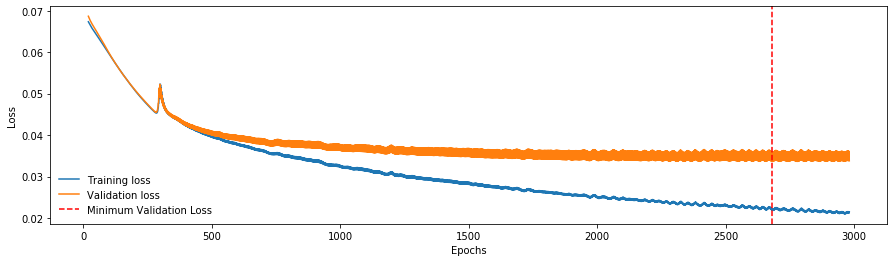

In [25]:
def plot_losses(burn_in=20):
    plt.figure(figsize=(15,4))
    plt.plot(list(range(burn_in, len(train_loss))), train_loss[burn_in:], label='Training loss')
    plt.plot(list(range(burn_in, len(valid_loss))), valid_loss[burn_in:], label='Validation loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Minimum Validation Loss')

    plt.legend(frameon=False)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
plot_losses()

## Evaluation

### Predict on test set

In [26]:
net.eval()
pred = net(x_test)
loss = criterion(pred, y_test)

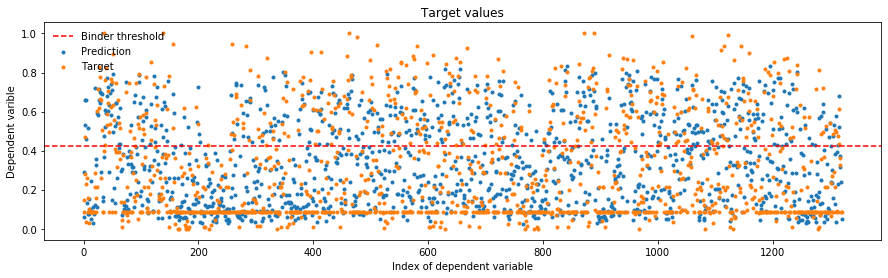

In [27]:
plot_target_values(data=[(pd.DataFrame(pred.data.numpy(), columns=['target']), 'Prediction'),
                         (test_raw, 'Target')])

### Transform targets to class

In [28]:
y_test_class = np.where(y_test.flatten() >= BINDER_THRESHOLD, 1, 0)
y_pred_class = np.where(pred.flatten() >= BINDER_THRESHOLD, 1, 0)

### Receiver Operating Caracteristic (ROC) curve

In [29]:
def plot_roc_curve(peptide_length=[9]):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC = %0.2f (%smer)' %(roc_auc, '-'.join([str(i) for i in peptide_length])))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], c='black', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

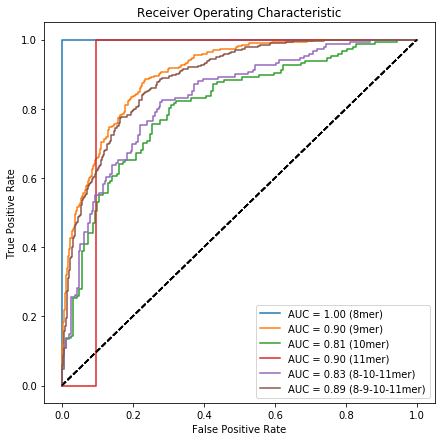

In [30]:
# Combining targets and prediction values with peptide length in a dataframe
pred_per_len = pd.DataFrame([test_raw.peptide.str.len().to_list(),
                             y_test_class,
                             pred.flatten().detach().numpy()],
                            index=['peptide_length','target','prediction']).T

plt.figure(figsize=(7,7))
# For each peptide length compute AUC and plot ROC
for length, grp in pred_per_len.groupby('peptide_length'):
    fpr, tpr, threshold = roc_curve(grp.target, grp.prediction)
    roc_auc = auc(fpr, tpr)
    
    plot_roc_curve(peptide_length=[int(length)])

# Evaluating model on peptides of length other than 9 AA.
for lengths in [[8,10,11],[8,9,10,11]]:
    grp = pred_per_len[pred_per_len.peptide_length.isin(lengths)]

    fpr, tpr, threshold = roc_curve(grp.target, grp.prediction)
    roc_auc = auc(fpr, tpr)

    plot_roc_curve(peptide_length=lengths)

### Matthew's Correlation Coefficient (MCC)

In [31]:
mcc = matthews_corrcoef(y_test_class, y_pred_class)

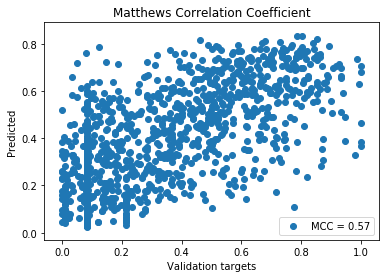

In [32]:
def plot_mcc():
    plt.title('Matthews Correlation Coefficient')
    plt.scatter(y_test.flatten().detach().numpy(), pred.flatten().detach().numpy(), label = 'MCC = %0.2f' % mcc)
    plt.legend(loc = 'lower right')
    plt.ylabel('Predicted')
    plt.xlabel('Validation targets')
    plt.show()

plot_mcc()